# Clustering on Provider Attributes for Healthcare Fraud Detection
### Deborah Leong, Sam Nuzbrokh and Doug Devens

This is a clustering analysis to determine if unsupervised learning models could match up with the labels provided from Kaggle for the training set.

Import required packages, including Kmeans model.

In [3]:
from __future__ import print_function
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
from sklearn.cluster import KMeans
kmeans = KMeans()
import pandas as pd

We are using the set of features from the random forest model, and the label set.

In [32]:
X_train_reduced = pd.read_csv('rf_reduced_feature_set')
y_train = pd.read_csv('rf_reduced_label_set')

Remove junk columns acquired during reding in file.

In [50]:
X_train_reduced = X_train_reduced.drop(columns=['Unnamed: 0'])
X_train_reduced.columns

Index(['Age_out', 'ClaimDays_in', 'ClaimDays_out', 'DeductibleAmtPaid_out',
       'Gender_out', 'InscClaimAmtReimbursed_in', 'InscClaimAmtReimbursed_out',
       'NumChronics_in', 'NumChronics_out', 'NumDiag_out', 'NumProc_in',
       'State_out', 'WhetherDead_out', 'ClaimDays_in_Range',
       'InscClaimAmtReimbursed_in_Range', 'InscClaimAmtReimbursed_out_Range',
       'NumChronics_in_Range', 'NumChronics_out_Range', 'NumDiag_in_Range',
       'NumDiag_out_Range', 'NumProc_in_Range', 'docMANN', 'patDegMax',
       'patBtwnMean', 'patEignMean', 'patMANN', 'ClmsPerPatient_in',
       'ClmsPerPatient_out', 'DrPerPatient_in', 'DrPerPatient_out',
       'LogPatients_in', 'LogPatients_out', 'LogClaims_in', 'LogClaims_out',
       'LogOpPhys_out', 'AgeRange_otpt', 'cardiology_otpt', 'urology_otpt',
       'endocrinology_otpt', 'emergency_otpt', 'oncology_otpt',
       'hematology_otpt', 'psychiatry_otpt', 'neurology_otpt',
       'pulmonology_otpt', 'gastroenterology_otpt', 'ob-gyn_otpt',


We start by assuming 2 clusters (fraud and potential fraud) and then train the model to those data.  We identify the cluster center locations in the feature space, and save the labels obtained from the model.

In [51]:
kmeans.set_params(n_clusters=2, n_jobs = 2)
kmeans.fit(X_train_reduced)
clust_ctr_list = kmeans.cluster_centers_
point_labl_list = kmeans.labels_

This was done after the random forest and gradient boost models, so we look at the feature dimensions where there is the most separation between clusters.  The top features should, nominally, be like our tree-based models, since we see the number of claims, the number of patients and the age range of the patients among the largest feature separations.

In [91]:
cluster_centers = pd.DataFrame(list(zip(X_train_reduced.columns,clust_ctr_list[0],clust_ctr_list[1])))
cluster_centers['Distance_along_feature']=abs(cluster_centers[1]-cluster_centers[2])
cluster_centers.columns=['Feature','Cluster_1','Cluster_2','Distance_along_feature']
cluster_centers=cluster_centers.sort_values(by='Distance_along_feature', ascending=False)
cluster_centers.head(15)

,Feature,Cluster_1,Cluster_2,Distance_along_feature
18,NumDiag_in_Range,1.196029e-04,0.562017,0.561897
16,NumChronics_in_Range,1.467854e-04,0.557591,0.557444
7,NumChronics_in,1.289020e-02,0.558133,0.545243
32,LogClaims_in,8.686399e-03,0.551301,0.542615
30,LogPatients_in,8.809243e-03,0.550512,0.541702
51,AgeRange_inpt,1.291712e-04,0.525624,0.525495
13,ClaimDays_in_Range,2.990073e-05,0.457184,0.457155
20,NumProc_in_Range,-3.608225e-15,0.396560,0.396560
28,DrPerPatient_in,1.973448e-02,0.408001,0.388266
26,ClmsPerPatient_in,1.022605e-02,0.361066,0.350840


We run a silhouette score on the separation we obtained.  The sihouette score is not very good (higher is better) with relatively mediocre performance.

In [60]:
from sklearn.metrics import confusion_matrix, classification_report, silhouette_score
silhouette_score(X_train_reduced, point_labl_list, metric='euclidean', sample_size=None, random_state=None)

0.4496361830384978

A confusion matrix confirms the model does a poor job of predicting the fraud labels. We see the number of false positives are more than triple the number of true positives in the training set.

In [62]:
confusion_matrix(y_train, point_labl_list)

array([[2656, 1271],
       [  55,  346]])

We examine the change in inertia as we increase the number of clusters.  The thought is that if we increase the number of clusters they may more naturally separate into groups that could more neatly fit in the fraud and not fraud groups.

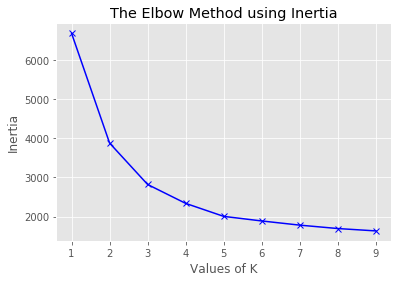

In [63]:
inertias = []
K = range(1,10)
for k in K:
    kmeans.set_params(n_clusters=k, n_jobs = 2)
    kmeans.fit(X_train_reduced)
    inertias.append(kmeans.inertia_)

plt.plot(K, inertias, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show() 


The elbow is ill-defined, but we assume that maybe 4 clusters will have lowered the inertia sufficiently to have groups that fit better into fraud and not fraud groups.

In [142]:
kmeans.set_params(n_clusters=4, n_jobs = 2)
kmeans.fit(X_train_reduced)
clust_ctr_list = kmeans.cluster_centers_
point_labl_list_new = kmeans.labels_
confusion_matrix(y_train, point_labl_list_new)

array([[ 893,  913, 1806,  315],
       [   1,  308,   54,   38],
       [   0,    0,    0,    0],
       [   0,    0,    0,    0]])

While the true negative grouping (top row) is still not neat with one clustering classfication largely empty of true negatives, we do see that the large majority of the true positives fall into cluster group 2 (second column from left.)  However, as we see below from the silhouette score that the clustering quality is not strong.

In [143]:
silhouette_score(X_train_reduced, point_labl_list_new, metric='euclidean', sample_size=None, random_state=None)

0.35960458896983877

We decide to move on to principal component analysis.  We import the package and the model and examine the explained variance.  This took several iterations, having started with 3 components and worked up to 7 to explain 85% of the variation.  As can be seen, the rest of the variance is explained through the remaining 62 dimensions of the feature space.  This seemed an appropriate amount with which to start.

In [95]:
import numpy as np
from sklearn.decomposition import PCA
pca = PCA()
pca.set_params(n_components=7)
pca.fit(X_train_reduced)
print(np.sum(pca.explained_variance_ratio_))
pca.explained_variance_ratio_

0.850377355673728


array([0.46561539, 0.26120905, 0.0491464 , 0.03460923, 0.01639075,
       0.01230389, 0.01110264])

We transform our feature space via the PCA.  We plotted the variance along the first principal component and we can see this dimension does seem to explain some of the variance of the classifications.  We see the frauds are clustered along higher values of the first principal component.

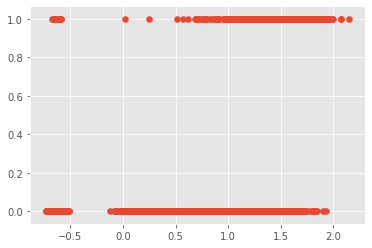

In [97]:
a = pca.fit_transform(X_train_reduced)
plt.scatter(a[:,0], y_train)

Because of the relatively large amount of variance explained by the PCA we decided to see if this could be useful with a logistic regression along the principal axes.  We did our PCA on the training set, and use test_train_split to train the logistic regression.

In [98]:
from sklearn import model_selection as ms
X_train, X_test, y_train1, y_test = ms.train_test_split(a, y_train, 
                                            test_size=0.20, random_state=42)

In [133]:
import sklearn.linear_model as lm

We recall sample weight is an option in the logistic classifer also.  An initial run with balanced class weights didn't appear to give very good F1 scores, with a relatively large number of false positives.  However, using the sample weight option yielded another way to improve model performance.  We iterated over several ranges of weights for the fraud (smaller) set of observations, and ended up with this range for the final examination.

In [140]:
for sw in [2.8,2.9,3,3.05,3.1]:
    sample_weight = np.array([1 if y==0 else sw for y in y_train1['PotentialFraud']])
    logit = lm.LogisticRegression(class_weight=None,C=1e5) 
    logit.fit(X_train, y_train1['PotentialFraud'],sample_weight=sample_weight)
    print()
    print(sw)
    print(confusion_matrix(y_test, logit.predict(X_test)))
    print(classification_report(y_test, logit.predict(X_test)))


2.8
[[732  42]
 [ 24  68]]
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       774
           1       0.62      0.74      0.67        92

    accuracy                           0.92       866
   macro avg       0.79      0.84      0.82       866
weighted avg       0.93      0.92      0.93       866


2.9
[[729  45]
 [ 24  68]]
              precision    recall  f1-score   support

           0       0.97      0.94      0.95       774
           1       0.60      0.74      0.66        92

    accuracy                           0.92       866
   macro avg       0.78      0.84      0.81       866
weighted avg       0.93      0.92      0.92       866


3
[[729  45]
 [ 22  70]]
              precision    recall  f1-score   support

           0       0.97      0.94      0.96       774
           1       0.61      0.76      0.68        92

    accuracy                           0.92       866
   macro avg       0.79      0.85      0.82   

We see a F1 score of 0.68, which is marginally higher than the random forest and gradient boost, with fewer false negatives and false positives than those models.  However, PCA has less interpretability whereas the feature importance of the tree-based models is helpful in discussing findings.

Finally, we examine hierarchical clustering to see if it works better than the kmeans. we import the package and set an instance of the model.

In [44]:
from sklearn.cluster import AgglomerativeClustering
hier = AgglomerativeClustering()

We again set the number of clusters at 2 (fraud and not fraud) and train it on the features from the random forest model.

In [45]:
hier.set_params(n_clusters=2)
hier.fit(X_train_reduced)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='ward', memory=None, n_clusters=2)

In [47]:
hier_point_labl_list = hier.labels_

We examine the performance of the hierarchical clustering model in its labeling of the fraud and not fraud.  We find it again has poor performance and stop examination here.

In [101]:
confusion_matrix(y_train, hier_point_labl_list)

array([[2561, 1366],
       [ 267,  134]])